In [1]:
import pandas as pd
import numpy as np
import vertica_python
import os
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [54]:
ltv_reg_year_query = """

SELECT
	a.fiscal_year_reg,
	a.fiscal_year_transaction,
	c.cnt_registered,
	d.cnt_enrolled_users,
	a.total_bookings,
	a.total_bookings/c.cnt_registered AS yearly_value,
	a.total_bookings/d.cnt_enrolled_users AS yearly_value_per_enrolled_users
FROM 
(
	SELECT
		CASE
			WHEN user_account_creation_time BETWEEN '2012-07-01' AND '2013-06-30' THEN 2013 
			WHEN user_account_creation_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN user_account_creation_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN user_account_creation_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN user_account_creation_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_reg,
		CASE
			WHEN DATE(transaction_date) BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN DATE(transaction_date) BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN DATE(transaction_date) BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN DATE(transaction_date) BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_transaction,
		SUM(COALESCE(transaction_amount, 0)) AS total_bookings
	FROM
		production.d_user a
	LEFT JOIN
		finance.f_orderitem_transactions b
	ON
		a.user_username = b.order_username
	JOIN
    	business_intelligence.course_master e
	ON
	    b.order_course_id = e.course_id
	AND
	    e.is_wl = 0
	GROUP BY
		1,2
) a
LEFT JOIN
(
	SELECT
		CASE
			WHEN user_account_creation_time BETWEEN '2012-07-01' AND '2013-06-30' THEN 2013 
			WHEN user_account_creation_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN user_account_creation_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN user_account_creation_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN user_account_creation_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_reg,
		COUNT(1) AS cnt_registered
	FROM
		production.d_user
	GROUP BY 
		1
) c
ON
	a.fiscal_year_reg = c.fiscal_year_reg
LEFT JOIN
(
	SELECT
		CASE
			WHEN user_account_creation_time BETWEEN '2012-07-01' AND '2013-06-30' THEN 2013 
			WHEN user_account_creation_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN user_account_creation_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN user_account_creation_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN user_account_creation_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_reg,
		CASE
			WHEN first_enrollment_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN first_enrollment_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN first_enrollment_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN first_enrollment_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_enroll,
		COUNT(DISTINCT a.user_id) AS cnt_enrolled_users
	FROM
		production.d_user a
	LEFT JOIN
		production.d_user_course b
	ON
		a.user_id = b.user_id
	GROUP BY 
		1,2
) d
ON
	a.fiscal_year_transaction = d.fiscal_year_enroll
AND
	a.fiscal_year_reg = d.fiscal_year_reg
WHERE
	a.fiscal_year_transaction IS NOT NULL
GROUP BY
	1,2,3,4,5;
"""

In [105]:
ltv_reg_year_country_query = """
SELECT
    a.user_last_location_country_code,
	a.fiscal_year_reg,
	a.fiscal_year_transaction,
	c.cnt_registered,
	d.cnt_enrolled_users,
	a.total_bookings,
	a.total_bookings/c.cnt_registered AS yearly_value,
	a.total_bookings/d.cnt_enrolled_users AS yearly_value_per_enrolled_users
FROM 
(
	SELECT
		CASE
			WHEN user_account_creation_time BETWEEN '2012-07-01' AND '2013-06-30' THEN 2013 
			WHEN user_account_creation_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN user_account_creation_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN user_account_creation_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN user_account_creation_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_reg,
		CASE
			WHEN DATE(transaction_date) BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN DATE(transaction_date) BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN DATE(transaction_date) BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN DATE(transaction_date) BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_transaction,
		a.user_last_location_country_code,
		SUM(COALESCE(transaction_amount, 0)) AS total_bookings
	FROM
		production.d_user a
	LEFT JOIN
		finance.f_orderitem_transactions b
	ON
		a.user_username = b.order_username
	JOIN
    	business_intelligence.course_master e
	ON
	    b.order_course_id = e.course_id
	AND
	    e.is_wl = 0
	GROUP BY
		1,2,3
) a
LEFT JOIN
(
	SELECT
		CASE
			WHEN user_account_creation_time BETWEEN '2012-07-01' AND '2013-06-30' THEN 2013 
			WHEN user_account_creation_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN user_account_creation_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN user_account_creation_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN user_account_creation_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_reg,
		user_last_location_country_code,
		COUNT(1) AS cnt_registered
	FROM
		production.d_user
	WHERE
		user_last_location_country_code IN
		(
			'US',
			'IN',
			'BR',
			'CA',
			'GB',
			'MX'
		)
	GROUP BY 
		1,2
) c
ON
	a.fiscal_year_reg = c.fiscal_year_reg
AND
	a.user_last_location_country_code = c.user_last_location_country_code
LEFT JOIN
(
	SELECT
		CASE
			WHEN user_account_creation_time BETWEEN '2012-07-01' AND '2013-06-30' THEN 2013 
			WHEN user_account_creation_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN user_account_creation_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN user_account_creation_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN user_account_creation_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_reg,
		CASE
			WHEN first_enrollment_time BETWEEN '2013-07-01' AND '2014-06-30' THEN 2014 
			WHEN first_enrollment_time BETWEEN '2014-07-01' AND '2015-06-30' THEN 2015 
			WHEN first_enrollment_time BETWEEN '2015-07-01' AND '2016-06-30' THEN 2016 
			WHEN first_enrollment_time BETWEEN '2016-07-01' AND '2017-06-30' THEN 2017 
		END AS fiscal_year_enroll,
		a.user_last_location_country_code,
		COUNT(DISTINCT a.user_id) AS cnt_enrolled_users
	FROM
		production.d_user a
	LEFT JOIN
		production.d_user_course b
	ON
		a.user_id = b.user_id
	WHERE
		user_last_location_country_code IN
		(
			'US',
			'IN',
			'BR',
			'CA',
			'GB',
			'MX'
		)
	GROUP BY 
		1,2,3
) d
ON
	a.fiscal_year_transaction = d.fiscal_year_enroll
AND
	a.fiscal_year_reg = d.fiscal_year_reg
AND
	a.user_last_location_country_code = d.user_last_location_country_code
WHERE
	a.fiscal_year_transaction IS NOT NULL
AND
	a.user_last_location_country_code IN
		(
			'US',
			'IN',
			'BR',
			'CA',
			'GB',
			'MX'
		)

"""

In [165]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(ltv_reg_year_query)
extract = cur.fetchall()
ltv_reg_year_df = pd.DataFrame(extract)

cur = connection.cursor('dict')

cur.execute(ltv_reg_year_country_query)
extract = cur.fetchall()
ltv_reg_year_country_df = pd.DataFrame(extract)

connection.close()

In [193]:
def prep_df(df):
    df = df[df.fiscal_year_transaction >= df.fiscal_year_reg]
    
    df['fiscal_year_reg'] = df['fiscal_year_reg'].astype('int')
    df['fiscal_year_transaction'] = df['fiscal_year_transaction'].astype('int')
    
    df['yearly_value'] = df['yearly_value'].astype('float64')
    df['yearly_value_per_enrolled_users'] = df['yearly_value_per_enrolled_users'].astype('float64')

#     df = df.rename(columns = {'fiscal_year_reg': 'Acquisition_Year'})
    df = df[df.fiscal_year_reg >= 2014]
    df['pct_users_enrolled'] = df.cnt_enrolled_users*100.0/df.cnt_registered
    df['year_delta'] = df['fiscal_year_transaction'] - df['fiscal_year_reg']
    
    return df

In [194]:
ltv_reg_year_df = prep_df(ltv_reg_year_df)
ltv_reg_year_country_df = prep_df(ltv_reg_year_country_df)

In [195]:
ltv_reg_year_df#.dtypes

,fiscal_year_reg,fiscal_year_transaction,cnt_registered,cnt_enrolled_users,total_bookings,yearly_value,yearly_value_per_enrolled_users,pct_users_enrolled,year_delta,cumulative_yearly_value
7,2014,2014,1494331.0,1317142.0,725268.50,0.485347,0.485347,88.142587,0,0.485347
14,2014,2015,1494331.0,568839.0,1017060.31,0.680612,1.165959,38.066466,1,1.165959
3,2014,2016,1494331.0,330488.0,1008911.63,0.675159,1.841118,22.116118,2,1.841118
9,2014,2017,1494331.0,263927.0,1223281.90,0.818615,2.659734,17.661883,3,2.659734
13,2015,2015,2051137.0,1831726.0,2555529.71,1.245909,1.245909,89.302957,0,1.245909
0,2015,2016,2051137.0,500044.0,1761586.19,0.858834,2.104743,24.378869,1,2.104743
17,2015,2017,2051137.0,357189.0,1712971.70,0.835133,2.939876,17.414195,2,2.939876
8,2016,2016,3641125.0,3315586.0,5470402.18,1.502393,1.502393,91.059384,0,1.502393
15,2016,2017,3641125.0,677722.0,3710438.00,1.019036,2.521430,18.612984,1,2.521430
2,2017,2017,3755212.0,3431804.0,8874870.55,2.363347,2.363347,91.387757,0,2.363347


In [196]:
ltv_reg_year_df = ltv_reg_year_df.sort_values(by = ['fiscal_year_reg', 'year_delta'])
ltv_reg_year_df['cumulative_yearly_value'] = ltv_reg_year_df.groupby(['fiscal_year_reg']).cumsum()['yearly_value']
ltv_reg_year_df['yearly_value_per_enrolled_users'] = ltv_reg_year_df.groupby(['fiscal_year_reg']).cumsum()['yearly_value']

In [197]:
ltv_reg_year_country_df = ltv_reg_year_country_df.sort_values(by = ['user_last_location_country_code','fiscal_year_reg', 'year_delta'])
ltv_reg_year_country_df['cumulative_yearly_value'] = ltv_reg_year_country_df.groupby(['user_last_location_country_code', 'fiscal_year_reg']).cumsum()['yearly_value']
ltv_reg_year_country_df['yearly_value_per_enrolled_users'] = ltv_reg_year_country_df.groupby(['user_last_location_country_code', 'fiscal_year_reg']).cumsum()['yearly_value']


In [198]:
gradient_palette = sns.light_palette("teal", 4)
sns.set_style("darkgrid")
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 4})

In [200]:
plot_list = ['yearly_value', 'yearly_value_per_enrolled_users', 'pct_users_enrolled', 'cumulative_yearly_value']
plot_list_short = ['yearly_value', 'yearly_value_per_enrolled_users']

In [209]:
def make_plots(df, is_country=False):
    if (is_country):
        for i in df.user_last_location_country_code.unique():
            
            temp_df = df[df.user_last_location_country_code == i]
            
            for j in plot_list:
                ax = sns.factorplot(
                    data = temp_df,
                    x = 'year_delta',
                    y = j,
                    hue = 'fiscal_year_reg',
                    kind = 'point',
                    size = 10,
                    palette = gradient_palette
                )
                ax.set(title = '%s vs Years from Reg FY, Country = %s' % (j,i),
                      xlabel = 'Years from Acquisition',
                      ylabel = j)       
                
            ax = sns.factorplot(
                data = temp_df[(temp_df.fiscal_year_reg == temp_df.fiscal_year_transaction)],
                x = 'fiscal_year_reg',
                y = 'yearly_value',
                kind = 'bar',
                size = 10,
                palette = gradient_palette
            )
            ax.set(title = 'First Year Value of New Users, by Reg FY, Country = %s' % i,
                  xlabel = 'Year',
                  ylabel = 'Yearly Value per User')
            
    else:
        for j in plot_list:
            ax = sns.factorplot(
                data = df,
                x = 'year_delta',
                y = j,
                hue = 'fiscal_year_reg',
                kind = 'point',
                size = 10,
                palette = gradient_palette
            )
            ax.set(title = '%s vs Years from Reg FY' % j,
                  xlabel = 'Years from Acquisition',
                  ylabel = j)
        
        ax = sns.factorplot(
            data = ltv_reg_year_df[ltv_reg_year_df.fiscal_year_reg == ltv_reg_year_df.fiscal_year_transaction],
            x = 'fiscal_year_reg',
            y = 'yearly_value',
            kind = 'bar',
            size = 10,
            palette = gradient_palette
        )
        ax.set(title = 'First Year Value of New Users, by Reg FY',
              xlabel = 'Year',
              ylabel = 'Yearly Value per User')

## Overall

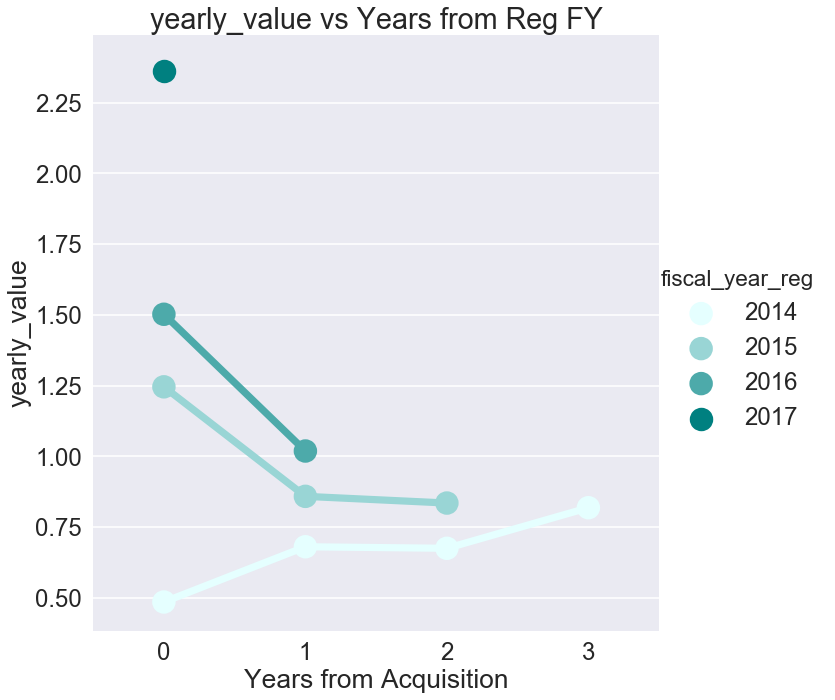

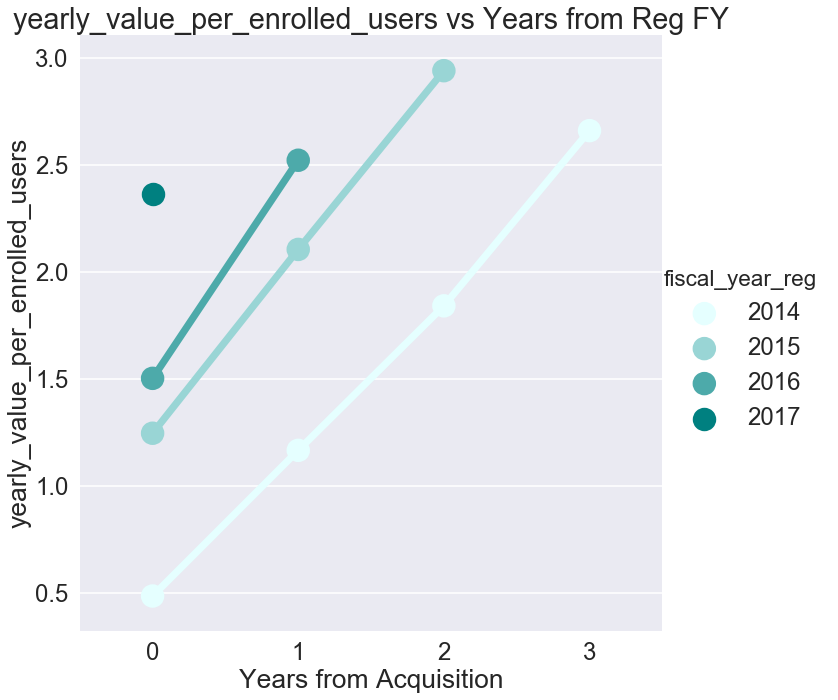

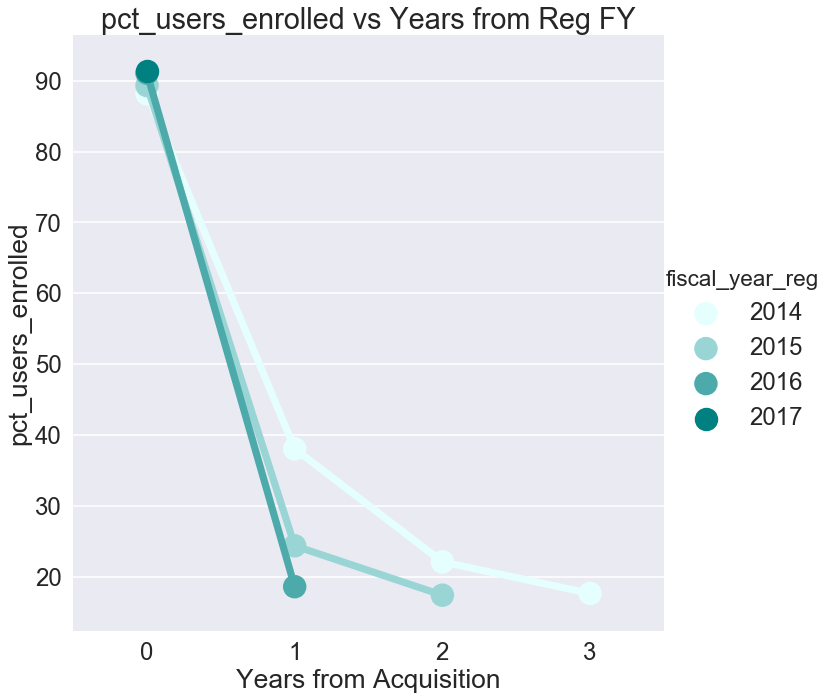

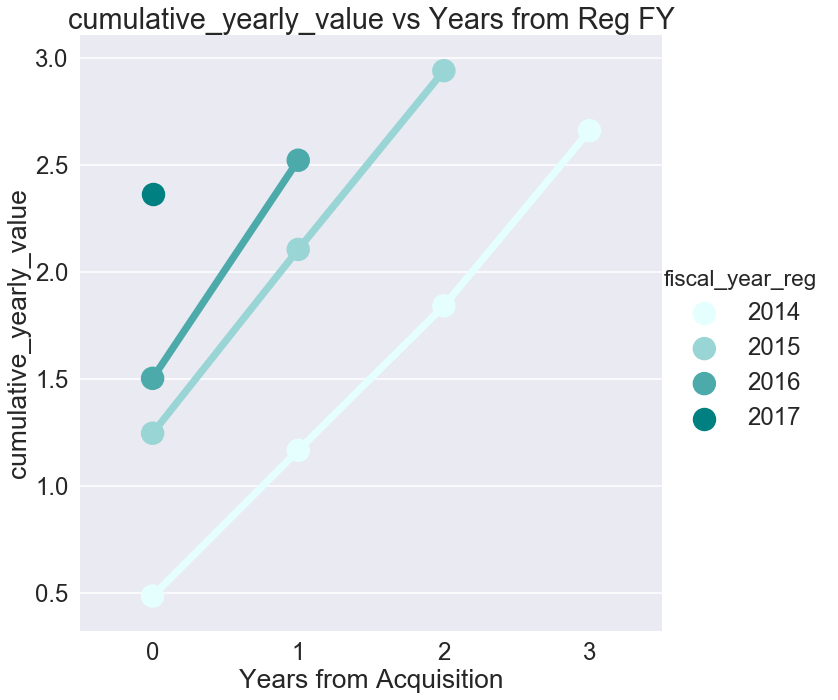

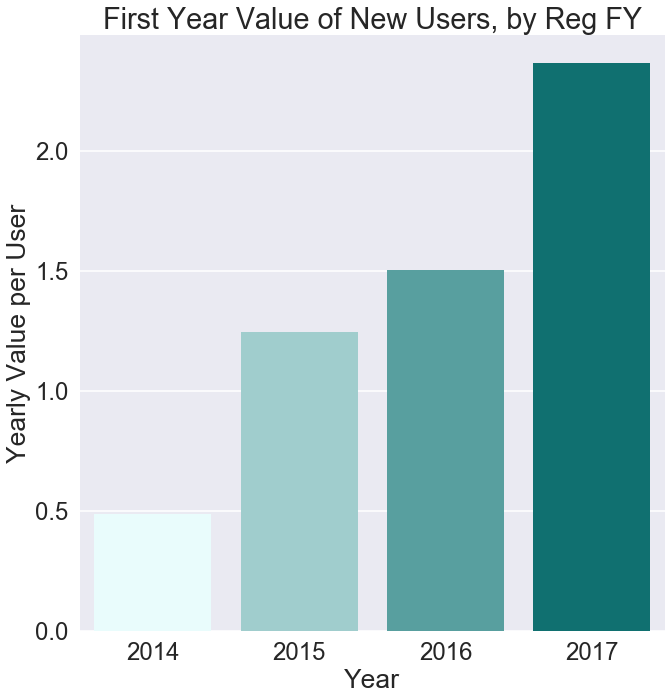

In [210]:
make_plots(ltv_reg_year_df)

In [211]:
ltv_reg_year_df.to_csv('./ltv_reg_year_df_to_csv.csv')

## By Country

/Users/adleyhemphill/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


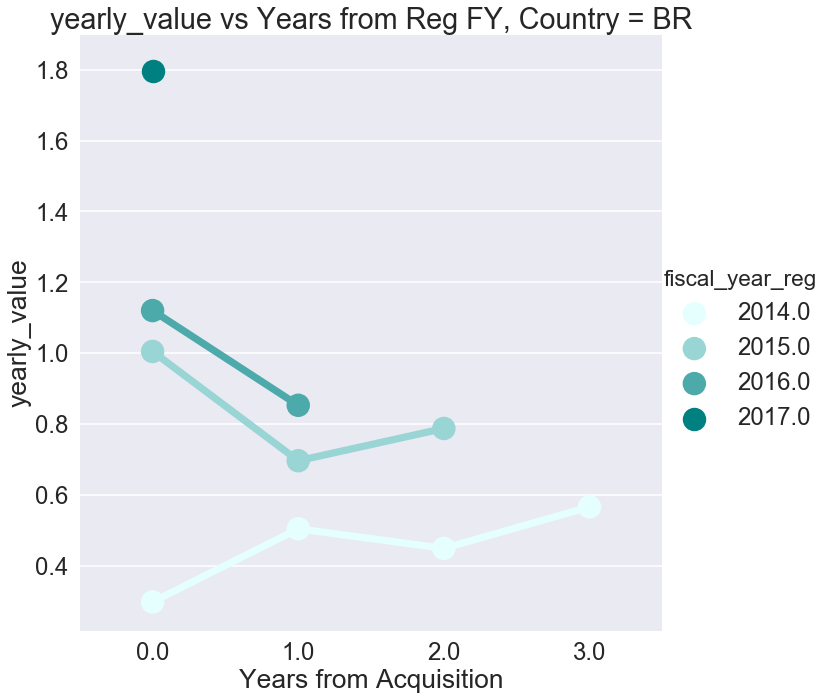

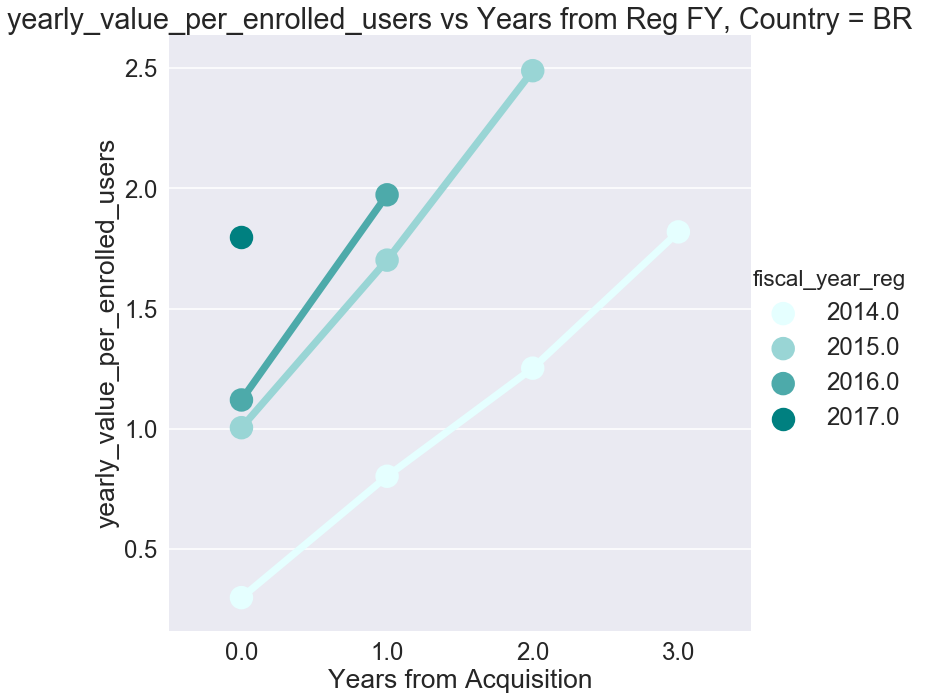

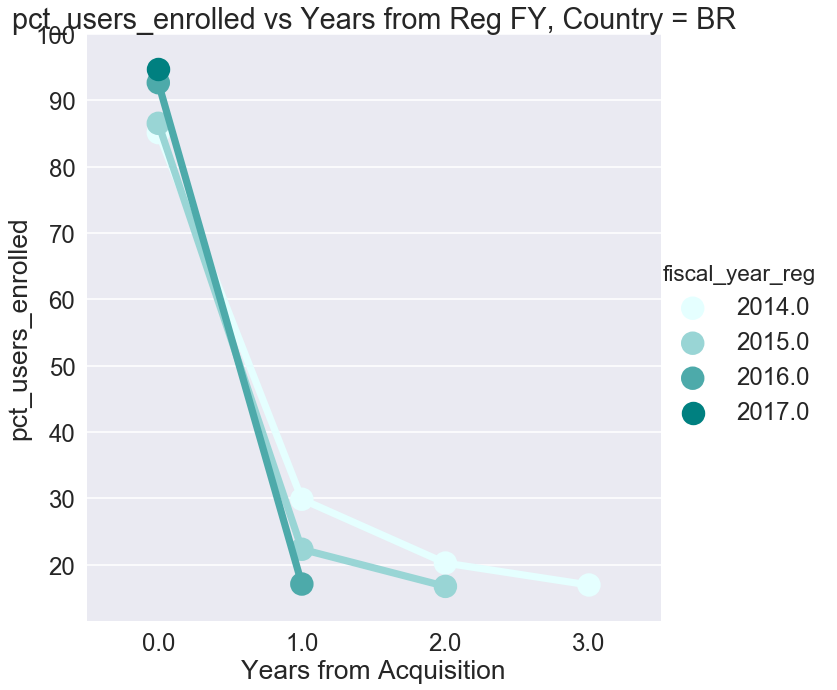

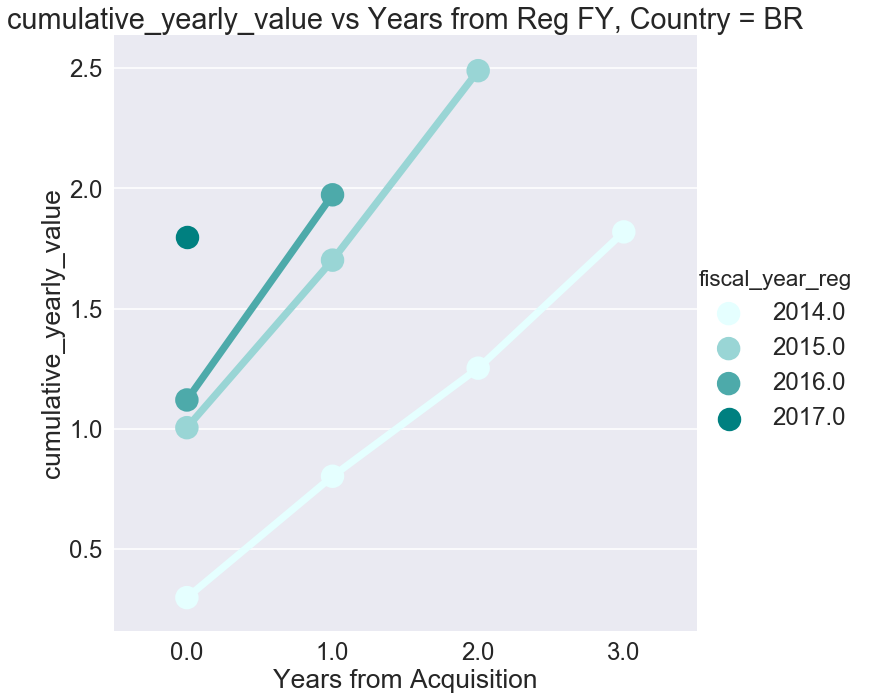

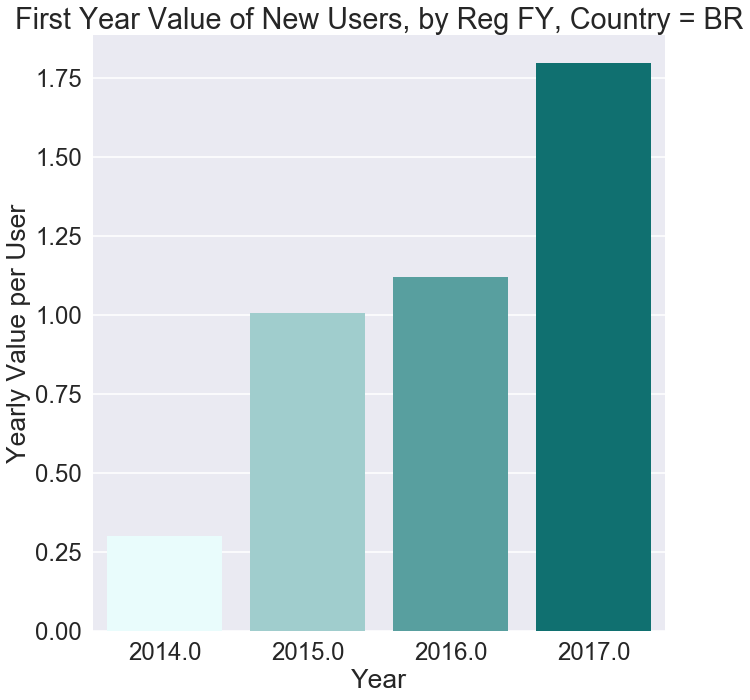

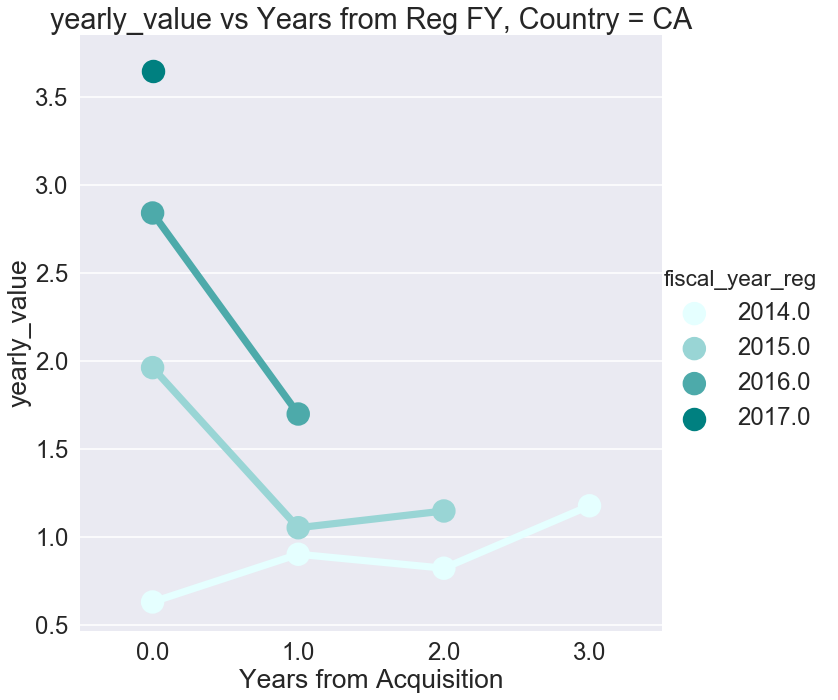

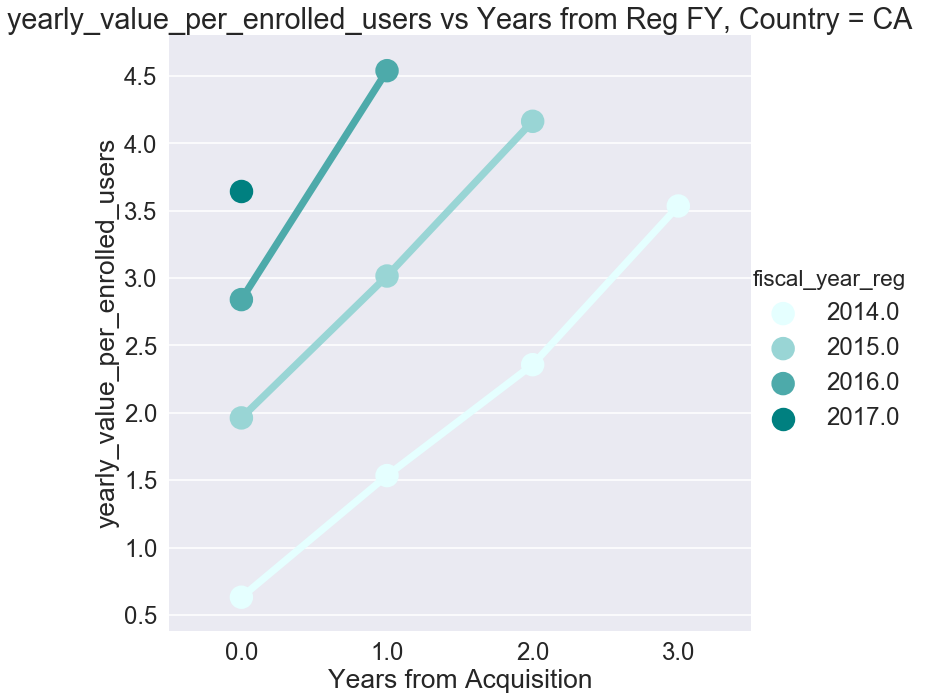

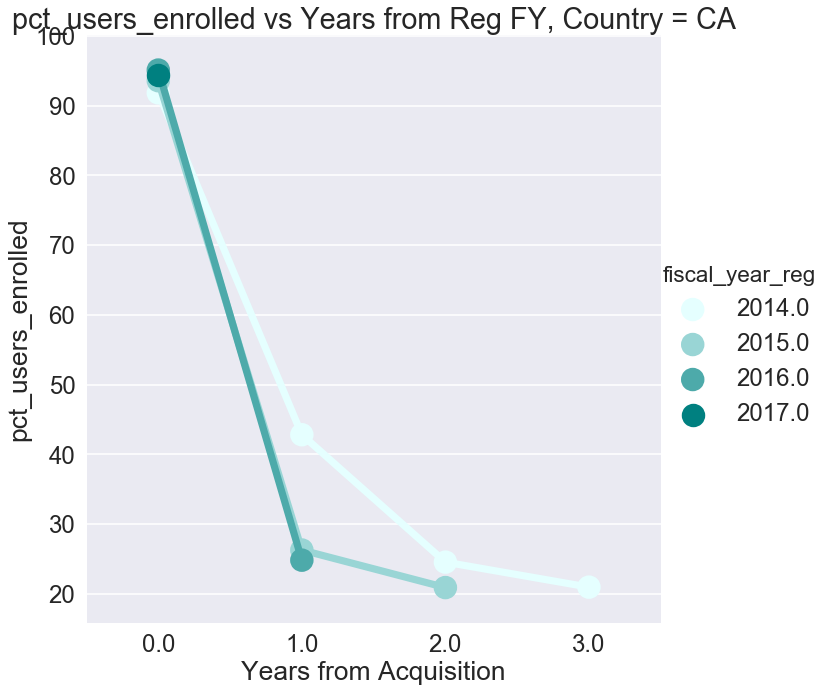

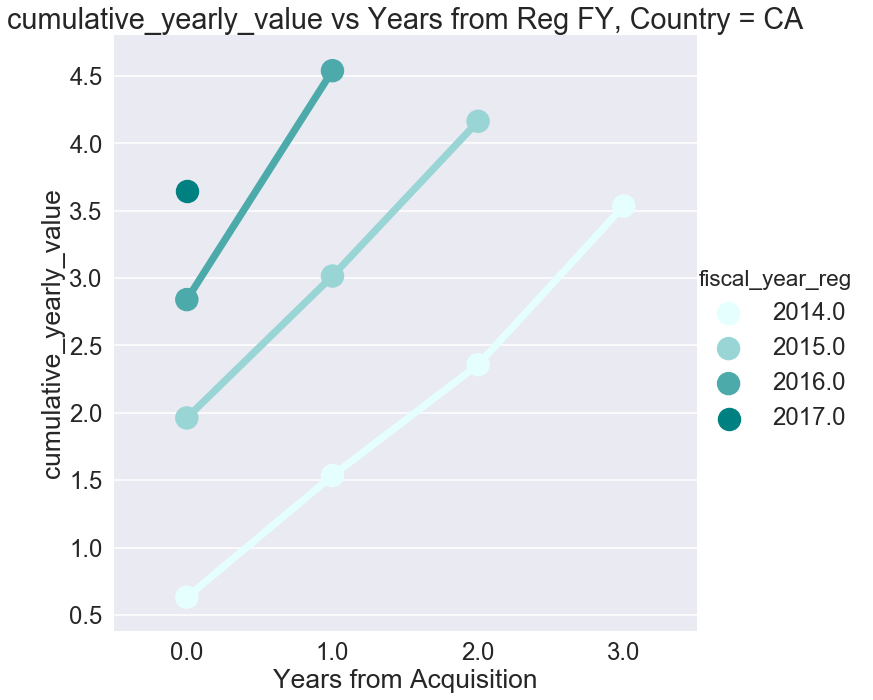

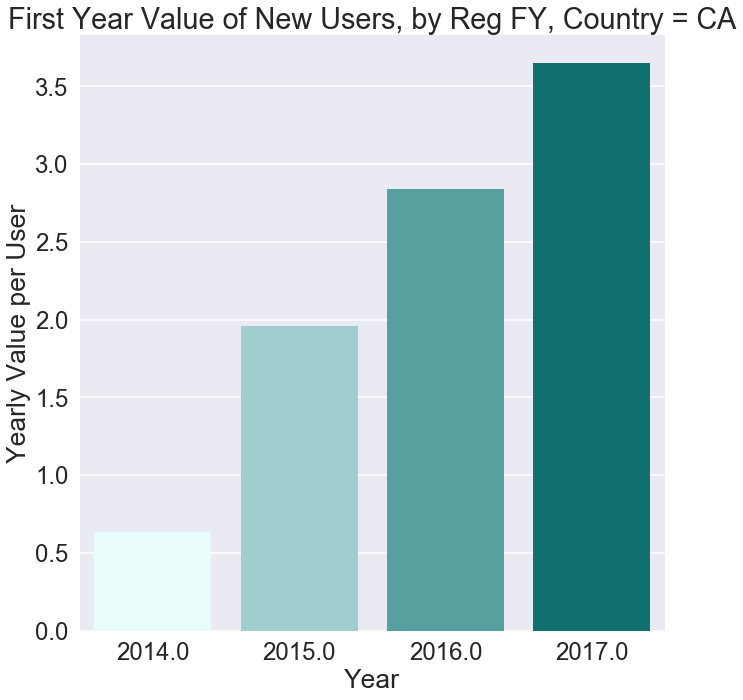

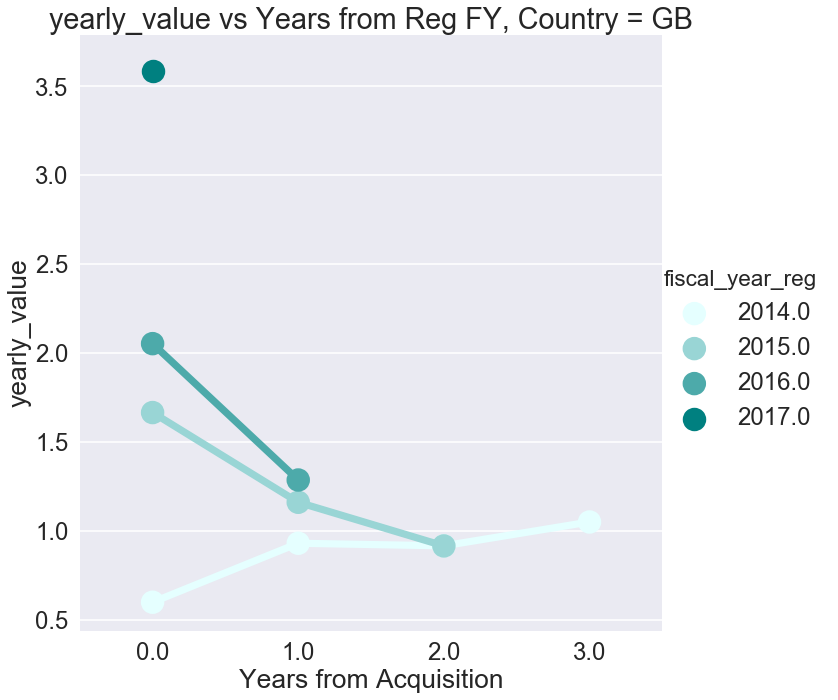

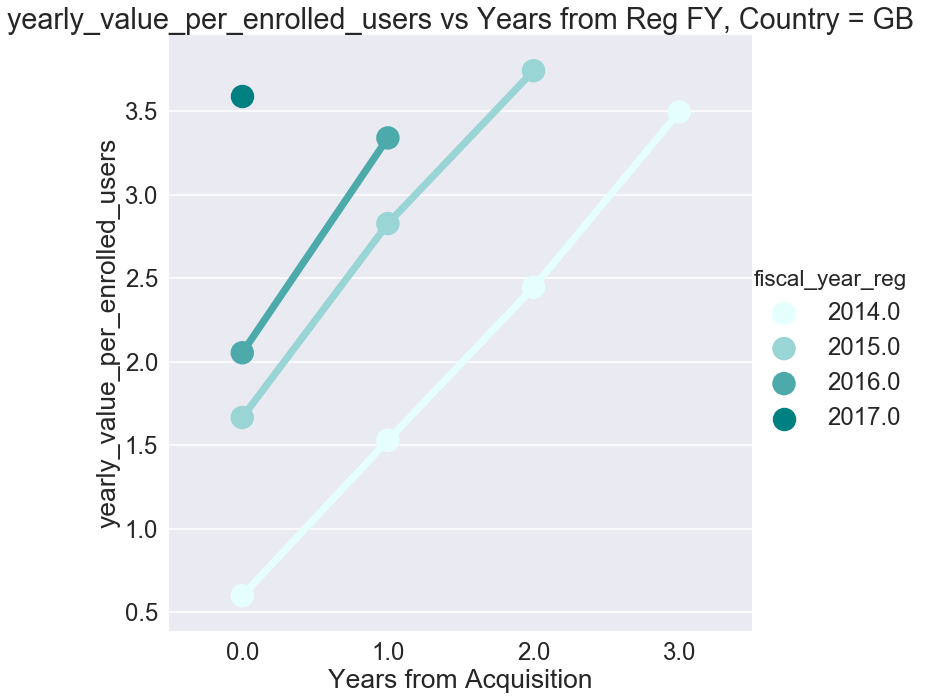

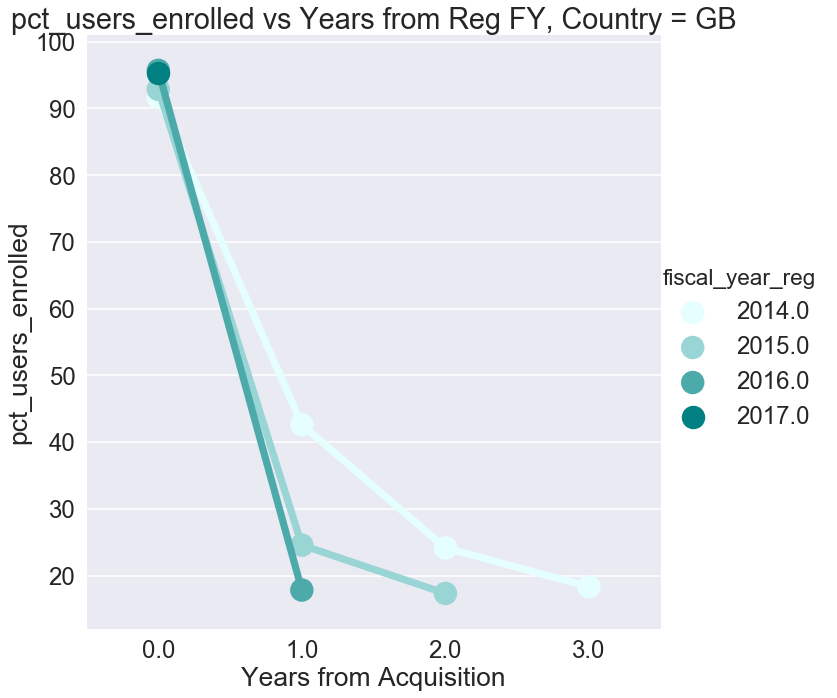

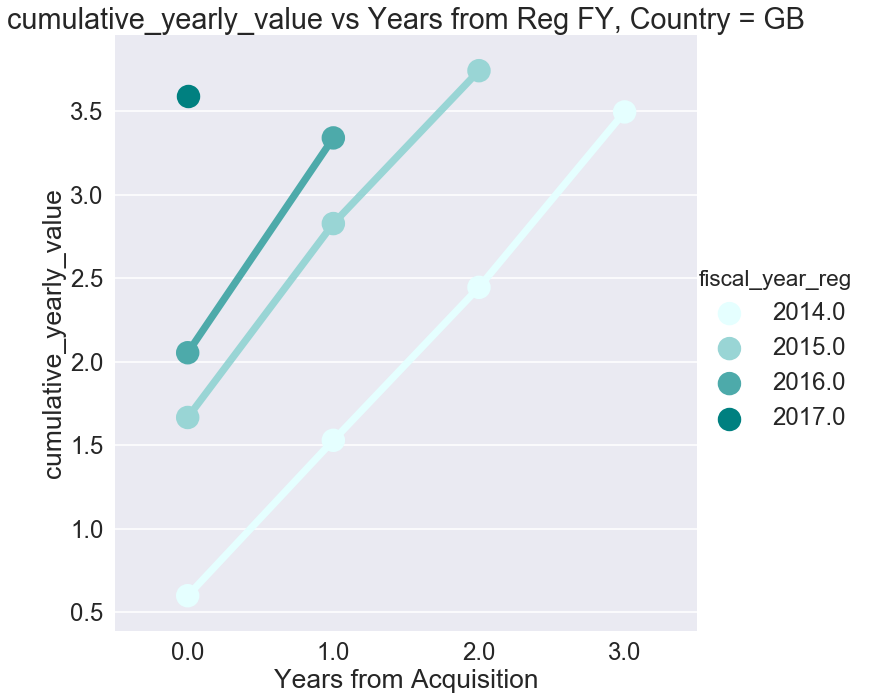

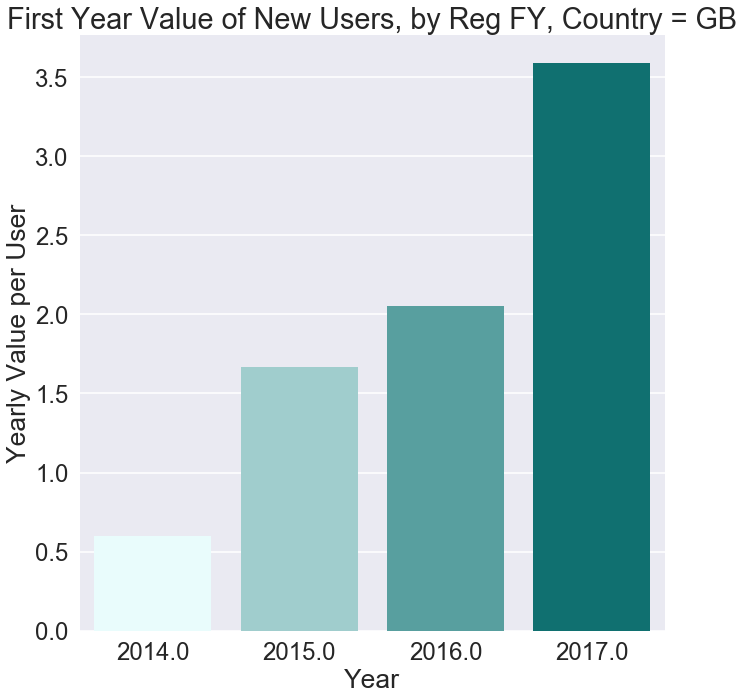

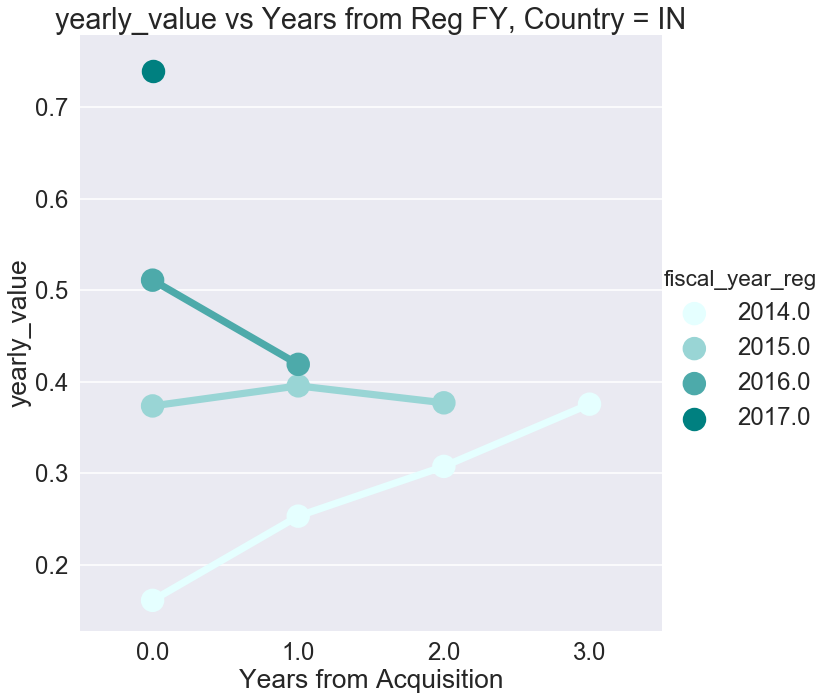

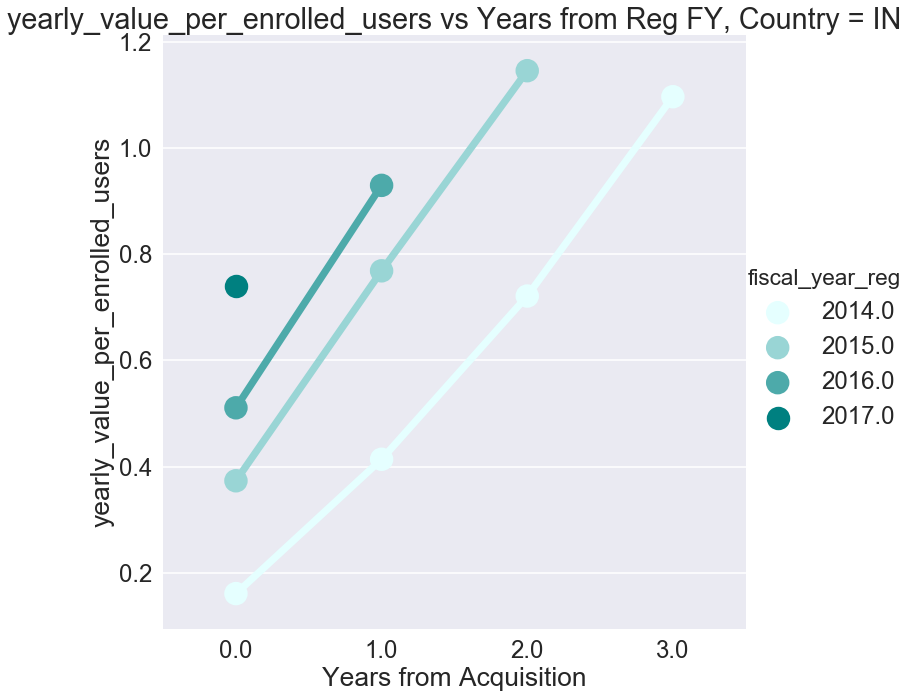

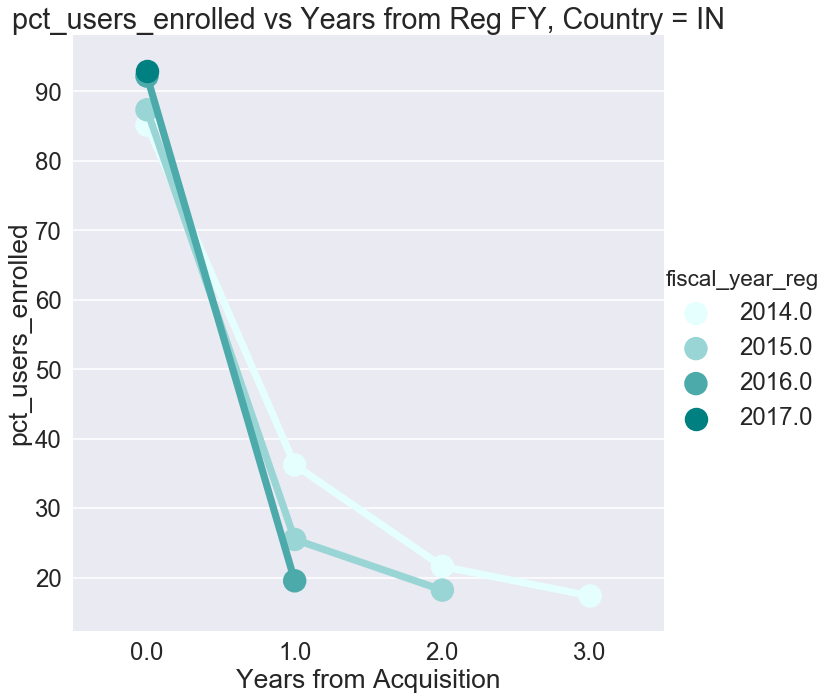

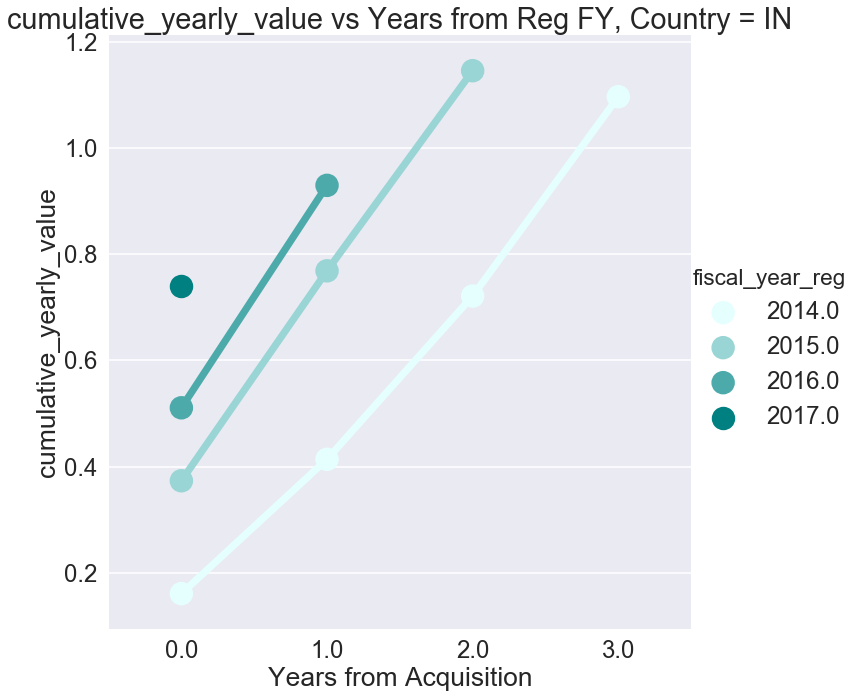

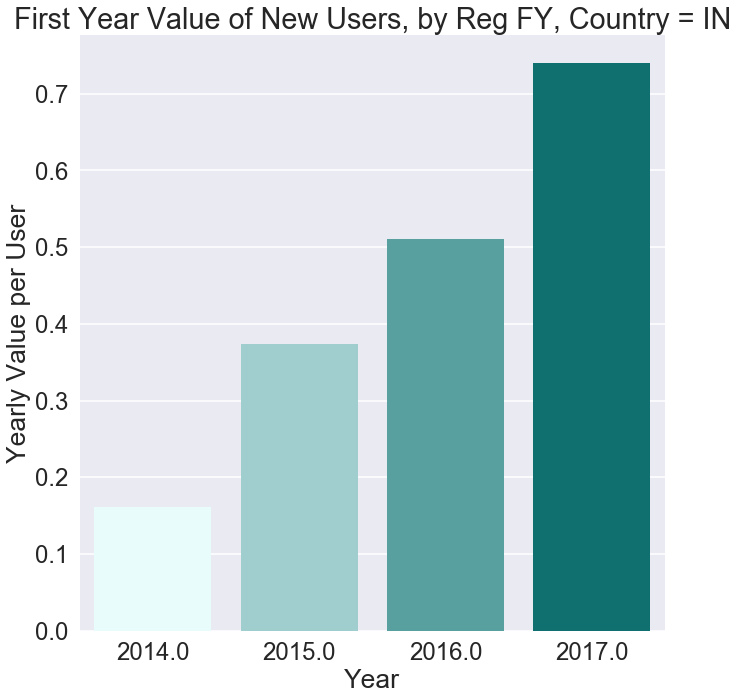

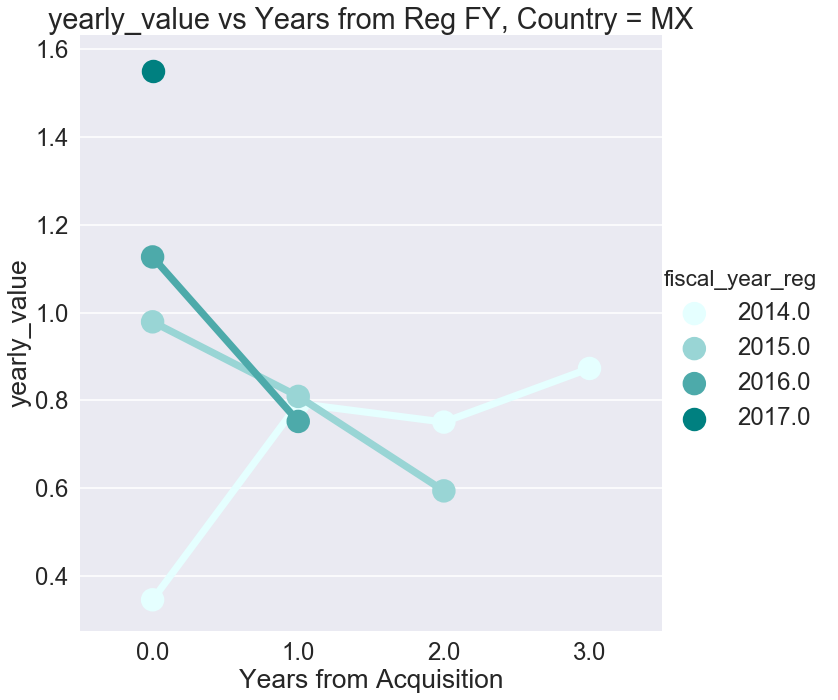

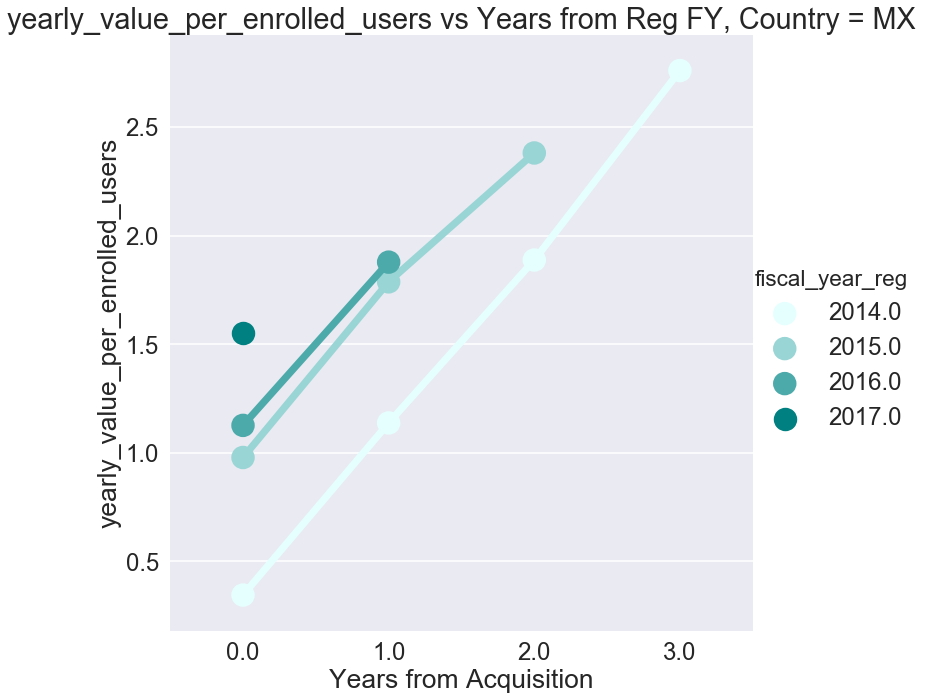

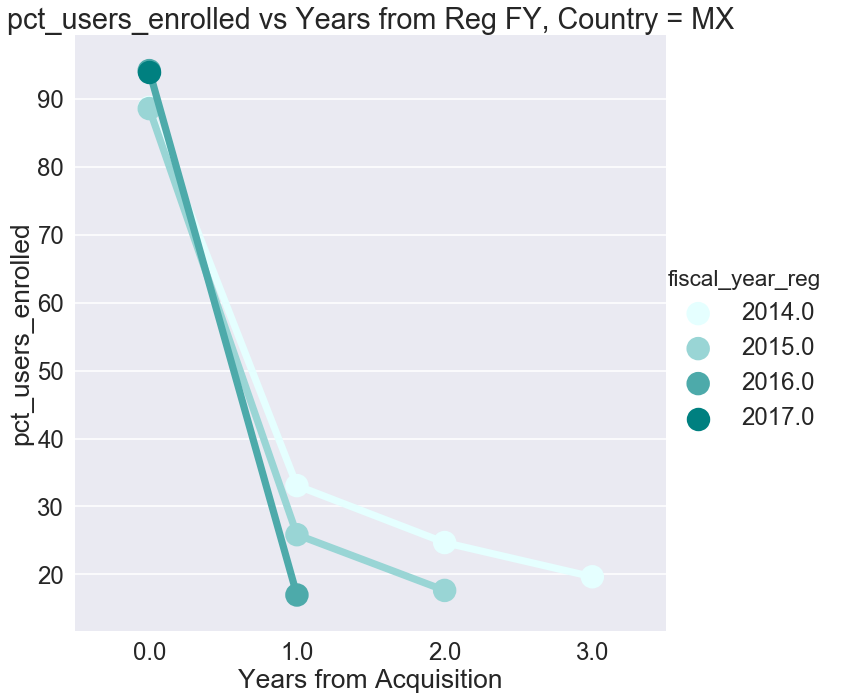

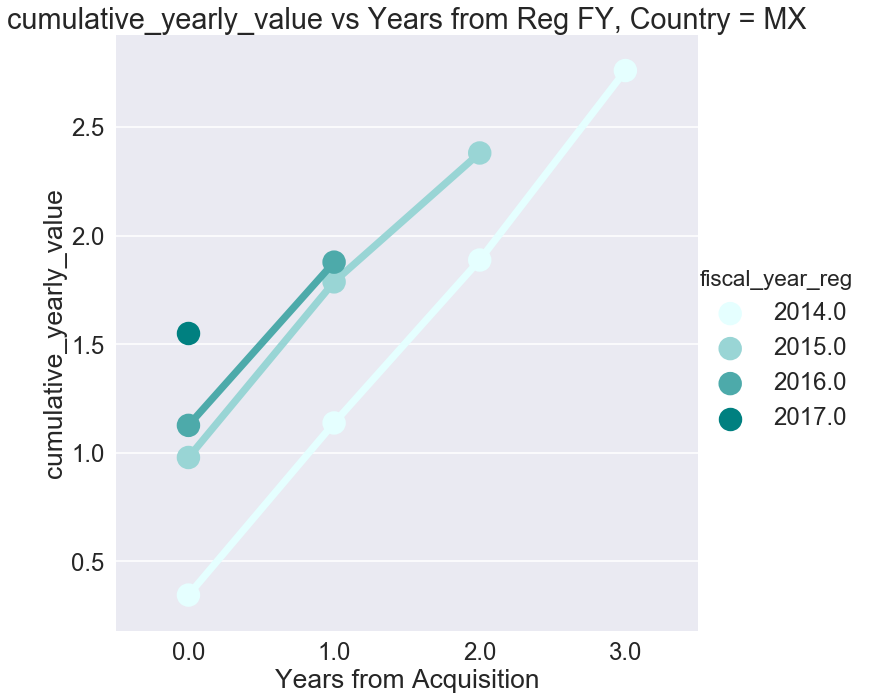

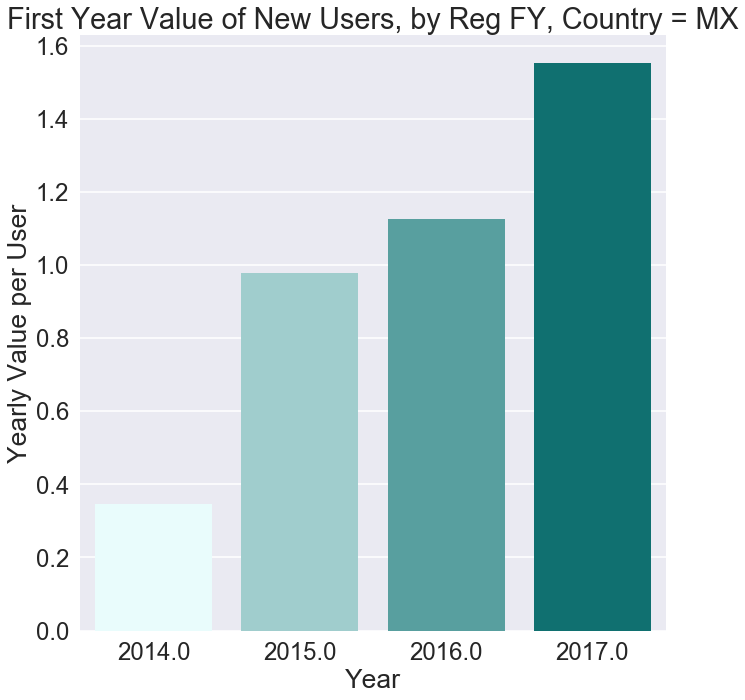

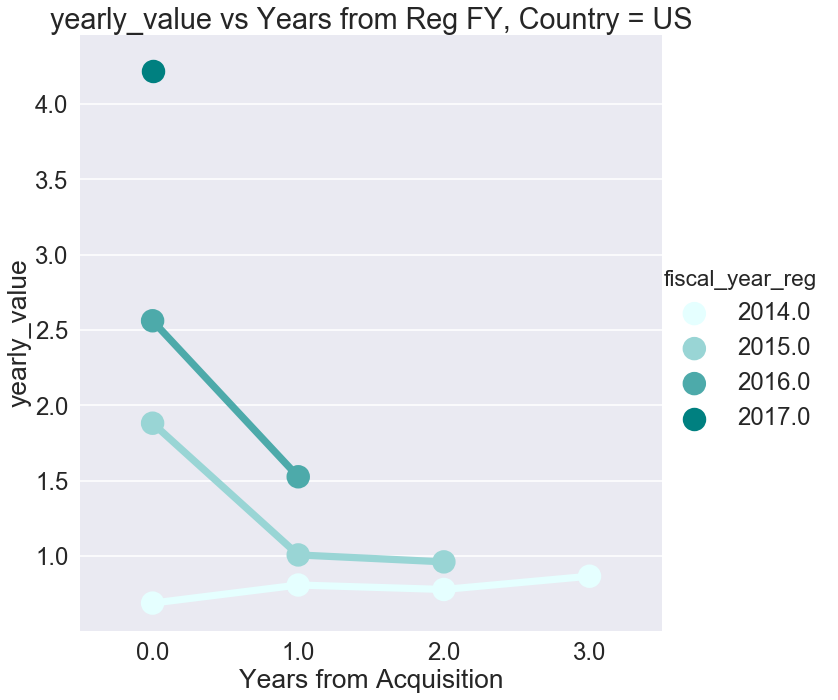

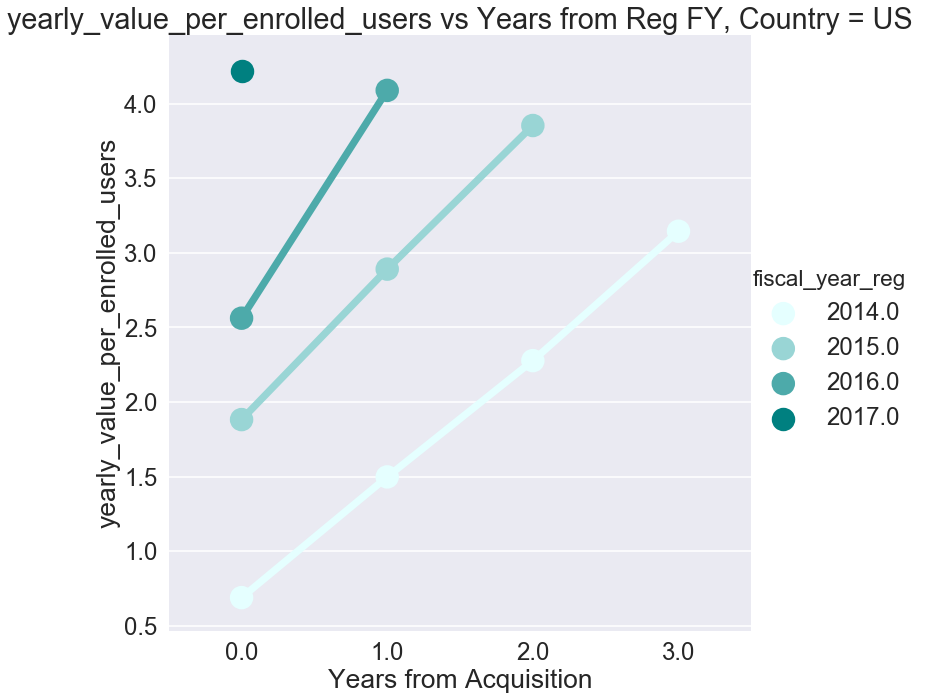

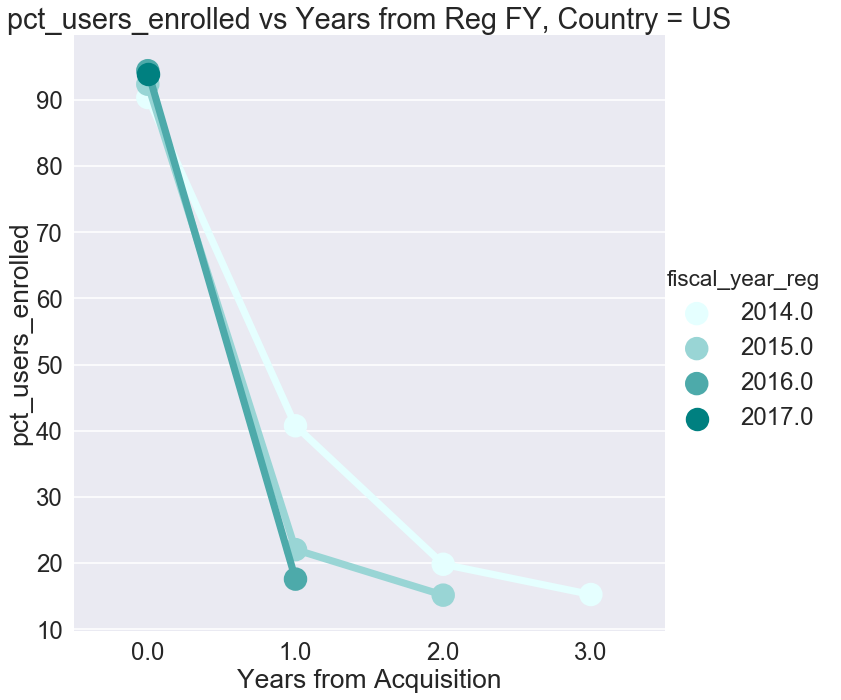

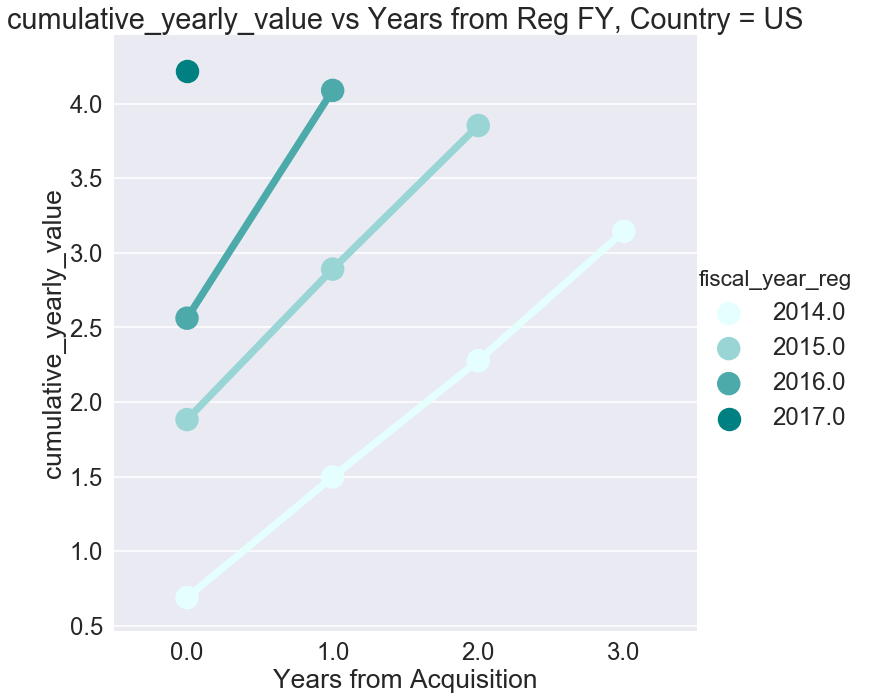

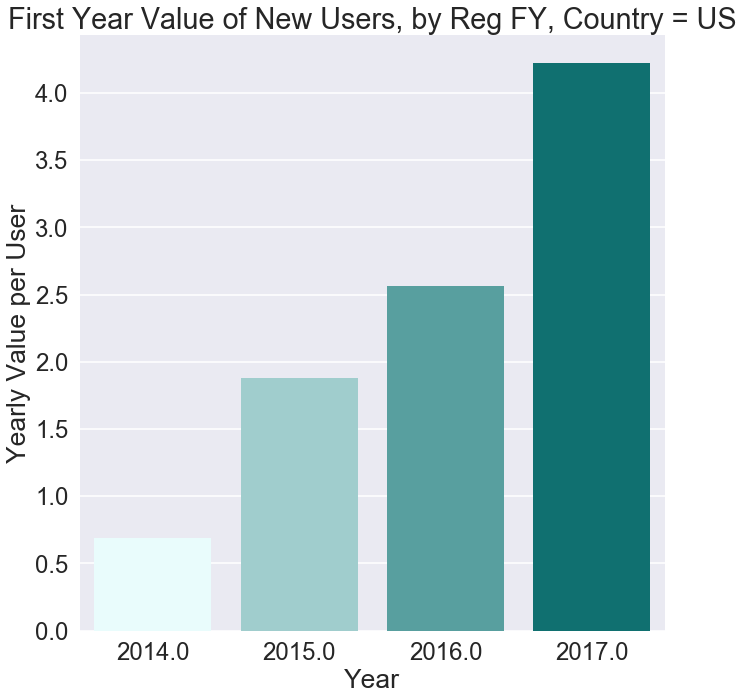

In [181]:
make_plots(ltv_reg_year_country_df, True)

In [212]:
ltv_reg_year_country_df.to_csv('./ltv_reg_year_country_df_to_csv.csv')

In [376]:
ltv_reg_year_country_df[ltv_reg_year_country_df.year_delta==0].groupby(
    'user_last_location_country_code').mean().reset_index()

,user_last_location_country_code,Acquisition_Year,year_transaction,cnt_registered,cnt_enrolled_users,yearly_value,yearly_value_per_enrolled_users,pct_users_enrolled,year_delta
0,BR,2015.5,2015.5,92848.25,85251.00,1.580101,1.725668,90.531764,0.0
1,CA,2015.5,2015.5,83331.25,78487.50,3.390579,3.594973,94.106521,0.0
2,GB,2015.5,2015.5,89383.75,84549.75,2.888219,3.051544,94.261185,0.0
3,IN,2015.5,2015.5,267054.25,242640.50,0.707918,0.779689,89.946849,0.0
4,MX,2015.5,2015.5,76611.75,70911.75,1.321912,1.434585,91.696501,0.0
5,US,2015.5,2015.5,586334.00,547686.75,4.565784,4.875815,93.303700,0.0


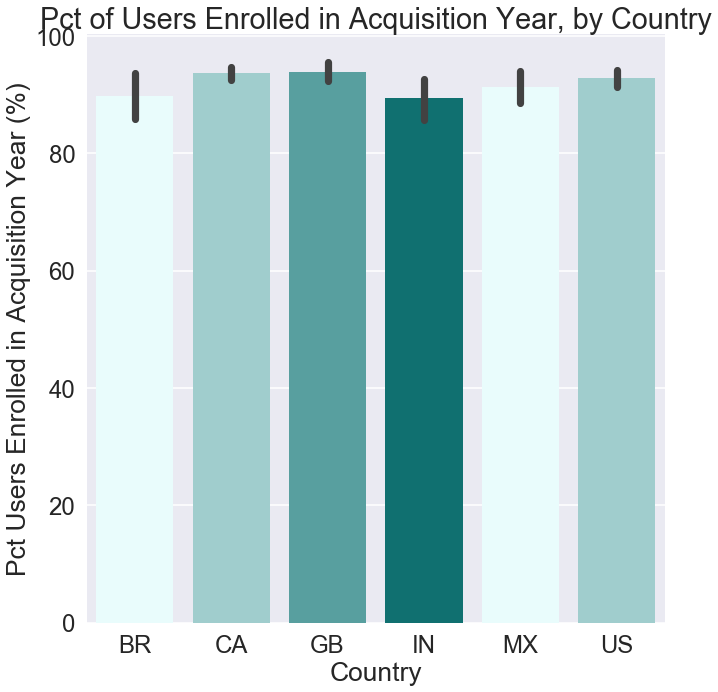

In [182]:
ax = sns.factorplot(
    data = ltv_reg_year_country_df[ltv_reg_year_country_df.year_delta==0],
    x = 'user_last_location_country_code',
    y = 'pct_users_enrolled',
    kind = 'bar',
    size = 10,
    palette = gradient_palette
)
ax.set(title = 'Pct of Users Enrolled in Acquisition Year, by Country',
      xlabel = 'Country',
      ylabel = 'Pct Users Enrolled in Acquisition Year (%)')

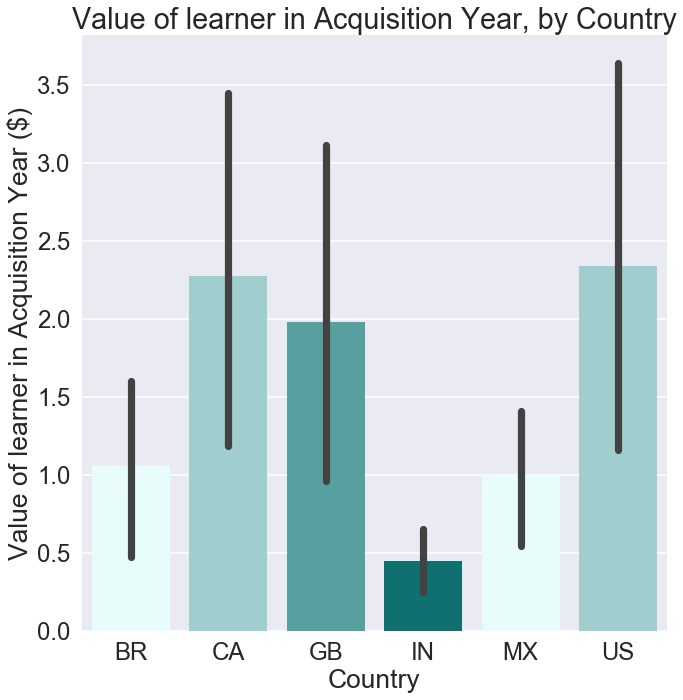

In [187]:
ax = sns.factorplot(
    data = ltv_reg_year_country_df[ltv_reg_year_country_df.year_delta==0],
    x = 'user_last_location_country_code',
    y = 'yearly_value',
    kind = 'bar',
    size = 10,
    palette = gradient_palette
)
ax.set(title = 'Value of learner in Acquisition Year, by Country',
      xlabel = 'Country',
      ylabel = 'Value of learner in Acquisition Year ($)')

In [ ]:
ltv_reg_year_df.to_csv('./bi-157.csv')